In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB1,EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from PIL import Image
import keras as K
from keras.models import load_model

# load the efficientB0 model

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(100,160,3))

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 100, 160, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 100, 160, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 101, 161, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

# Training the model with our data and save it

In [2]:
train_path = r'roi_image'

In [3]:
labels=os.listdir(train_path)
labels

['1', '2', '3', 'normal']

In [24]:
X_train = []
y_train = []
for i in labels:
    folderPath = os.path.join(train_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        X_train.append(img)
        y_train.append(i)

        

        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [25]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [26]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(1280, 100, 160, 3)

In [27]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.125,random_state=101)

In [28]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [29]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("rectangle_crop.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [31]:
hist=model.fit(X_train,y_train,validation_split=0.125, epochs =20, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\28261\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
62/62 [==============================] - 101s 1s/step - loss: 0.8533 - accuracy: 0.6418 - val_loss: 1.5241 - val_accuracy: 0.4500

Epoch 00001: val_accuracy improved from -inf to 0.45000, saving model to rectangle_crop.h5
Epoch 2/20
62/62 [==============================] - 82s 1s/step - loss: 0.3662 - accuracy: 0.8622 - val_loss: 0.9811 - val_accuracy: 0.6714

Epoch 00002: val_accuracy improved from 0.45000 to 0.67143, saving model to rectangle_crop.h5
Epoch 3/20
62/62 [==============================] - 80s 1s/step - loss: 0.2831 - accuracy: 0.9000 - val_loss: 0.8493 - val_accuracy: 0.7571

Epoch 00003: val_accuracy improved from 0.67143 to 0.75714, saving model to rectangle_crop.h5
Epoch 4/20
62/62 [==============================] - 81s 1s/step - loss: 0.1748 - accuracy: 0.9367 - val_loss: 0.8998 - val_accuracy: 0.7500

Epoch 00004: val_accuracy did not improve from 0.75714
Epoch 5/20
62/62 [==============================] - 82s 1s/step - loss: 0.1660 - accuracy: 0.9429 - v

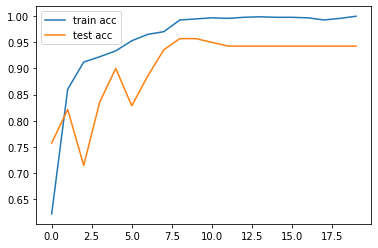

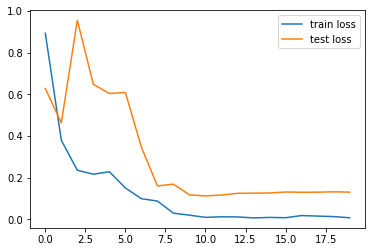

In [39]:
plt.plot(hist.history["accuracy"],label="train acc")
plt.plot(hist.history["val_accuracy"],label="test acc")
plt.legend()
plt.show()

plt.plot(hist.history["loss"],label="train loss")
plt.plot(hist.history["val_loss"],label="test loss")
plt.legend()
plt.show()